In [3]:
library("checkpoint")
checkpoint("2019-04-23")
library(ggplot2)
library(dplyr)
#install.packages('gridExtra')
library(gridExtra)
#install.packages('mgcv')
library(mgcv) #gam

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-22. For overview type 'help("mgcv-package")'.


In [4]:
dat <- read.csv('output/OpenSci3Discipline.csv', stringsAsFactors = FALSE)
nrow(dat) #2926
#number of papers in each literature
dat %>% group_by(Tag) %>% summarise(count=n())
# 1 OpenScience       879
# 2 Reproducibility  2047

[1] 2926

Tag,count
OpenScience,879
Reproducibility,2047


### Female participation analysis

In [5]:
# variables X1st, X2nd, etc. = 1 if female, 0 if male, NA if unknown

#Female First or Last Author
dat$femaleLead <- (dat$X1st==1) | (dat$last==1)
table(dat$femaleLead, dat$Tag)

#percent of multi-author papers with female lead (of those where it is observable)
dat %>% filter(authorCount > 1) %>% group_by(Tag) %>% 
  summarise(count_known=sum(!is.na(femaleLead)), 
            pct_femLead = sum(femaleLead, na.rm=TRUE)/count_known)

       
        OpenScience Reproducibility
  FALSE         336             613
  TRUE          364             652

Tag,count_known,pct_femLead
OpenScience,482,0.6058091
Reproducibility,995,0.5788945


In [6]:
#number of single-authored papers in each literature
dat %>% filter(authorCount==1) %>% group_by(Tag) %>% summarise(count=n())

#number of multi-authored papers in each literature
dat %>% filter(authorCount > 1) %>% group_by(Tag) %>% summarise(count=n())

#number of single-authored papers with female, male or unknown author gender
dat %>% filter(authorCount==1) %>% group_by(Tag, X1st) %>% summarise(count=n())

Tag,count
OpenScience,255
Reproducibility,342


Tag,count
OpenScience,624
Reproducibility,1705


Tag,X1st,count
OpenScience,0,146
OpenScience,1,72
OpenScience,NA,37
Reproducibility,0,194
Reproducibility,1,76
Reproducibility,NA,72


Tag,count
OpenScience,454
Reproducibility,955


Tag,count
OpenScience,28
Reproducibility,40


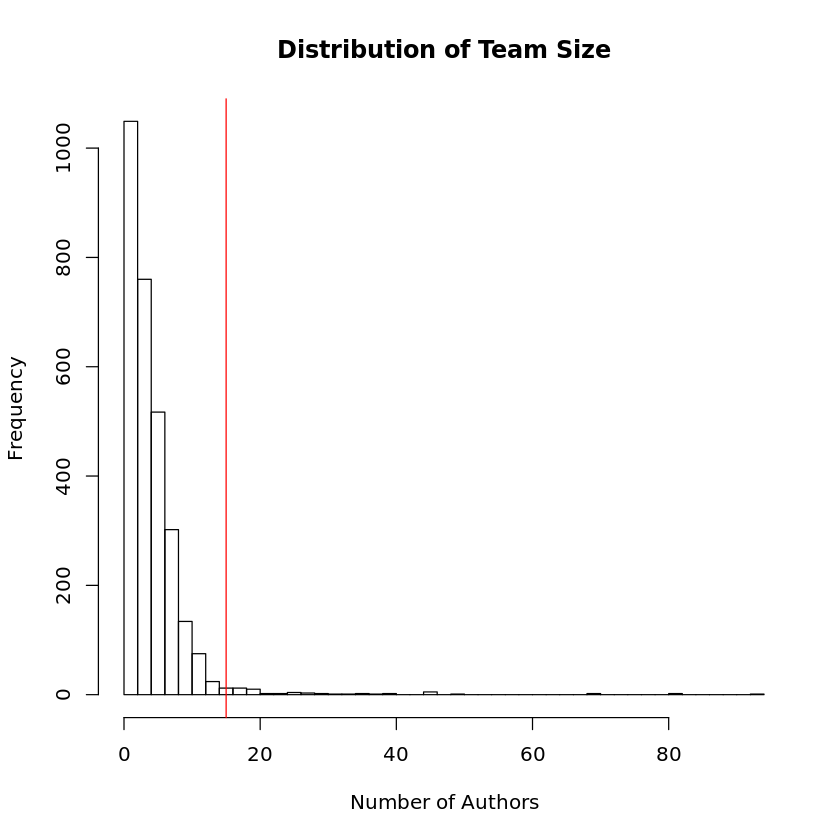

In [7]:
#distribution of team size
hist(dat$authorCount, breaks=seq(0,94,2), main='Distribution of Team Size', xlab='Number of Authors')
abline(v=15, col='red')

#sample size for regression
dat %>% filter(authorCount > 1, authorCount <= 12, !is.na(femaleLead)) %>% group_by(Tag) %>% summarise(count=n())
# 1 OpenScience       461
# 2 Reproducibility   970

#number of papers with more than 12 authors (excluded from regression)
dat %>% filter(authorCount > 12, !is.na(femaleLead)) %>% group_by(Tag) %>% summarise(count=n())

In [8]:
### Test for differences in rates of female vs. male authorship in single-author papers

tmp <- dplyr::filter(dat, authorCount==1)
tab <- table(tmp$femaleLead, tmp$Tag, useNA = 'ifany')
rownames(tab) <- c("Male","Female","Unknown")
tab
# OpenScience Reproducibility
# Male            146             194
# Female           72              76
# Unknown          37              72
round(tab/matrix(colSums(tab), nrow=3,ncol=2,byrow=TRUE),3)

         
          OpenScience Reproducibility
  Male            146             194
  Female           72              76
  Unknown          37              72

         
          OpenScience Reproducibility
  Male          0.573           0.567
  Female        0.282           0.222
  Unknown       0.145           0.211

In [9]:
### COMPARE RATES OF WOMEN IN SINGLE-AUTHOR PAPERS

# % of single-author papers written by women, among those with known gender
tab <- tab[1:2,] #exclude papers with unknown author gender 
n_OS <- sum(tab[,1])
n_RR <- sum(tab[,2])
n_fem_OS <- tab[2,1]
n_fem_RR <- tab[2,2]
pct_fem_OS <- n_fem_OS/n_OS #33% 
pct_fem_RR <- n_fem_RR/n_RR #28%

#H0: p = 0.5

#Normal approximation
t_OS <- (pct_fem_OS-0.5)/sqrt(0.5*0.5/n_OS)
t_RR <- (pct_fem_RR-0.5)/sqrt(0.5*0.5/n_RR)
pnorm(t_OS) #2.694587e-07
pnorm(t_RR) #4.888296e-13

[1] 2.694587e-07

[1] 3.453812e-13

In [10]:
#Exact test
pbinom(n_fem_OS, size = n_OS, prob = 0.5) #3.012727e-07
pbinom(n_fem_RR, size = n_RR, prob = 0.5) #3.286681e-13

#H0: p_OS = p_RR
pct_fem = (n_fem_OS+n_fem_RR)/(n_OS+n_RR)
t_compare <- (pct_fem_OS - pct_fem_RR)/sqrt(pct_fem*(1-pct_fem)*(1/n_OS + 1/n_RR))
pnorm(t_compare, lower.tail = FALSE) #p=0.1218532

[1] 3.012727e-07

[1] 2.279883e-13

[1] 0.1218532

### Exploratory Analysis

In [11]:
### Number of papers in each field over Time

pdf('figures/TimeHist.pdf', width=8, height=5)
par(mfrow=c(1,2))
par(cex.axis=0.7)
hist(dat$Year[dat$Tag=='OpenScience'], col=rgb(0,0,1,0.5), breaks=2010:2017, xlab='Year', xlim=c(2010,2017), main='Open Science', ylab='Number of Papers Published')
hist(dat$Year[dat$Tag=='Reproducibility'], col=rgb(0,0,1,0.5), breaks=2010:2017, xlab='Year', xlim=c(2010,2017), main='Reproducibility', ylab='Number of Papers Published')
dev.off()

png 
  2

In [12]:
### Number of papers in each field by Team Size

pdf('figures/TeamSizeHist.pdf', width=8, height=5)
par(mfrow=c(1,2))
par(cex.axis=0.7)
hist(dat$authorCount[dat$Tag=='OpenScience'], col=rgb(0,0,1,0.5), xlab='Number of Authors', xlim=c(0,20), breaks=seq(0,100), main='Open Science', ylab='Number of Papers Published')
hist(dat$authorCount[dat$Tag=='Reproducibility'], col=rgb(0,0,1,0.5), xlab='Number of Authors', xlim=c(0,20), breaks=seq(0,100), main='Reproducibility', ylab='Number of Papers Published')
dev.off()

png 
  2

In [23]:
### Team Size Distribution (**** FIGURE 3 ****)

#how many papers then excluded due to high number of authors?
dat %>% filter(authorCount > 1, !is.na(femaleLead), authorCount > 15) %>% group_by(Tag) %>% summarize(count=n())
# 1 OpenScience        21
# 2 Reproducibility    25

dat %>% filter(authorCount > 1, !is.na(femaleLead), authorCount > 20) %>% group_by(Tag) %>% summarize(count=n())
# 1 OpenScience        14
# 2 Reproducibility    15

pdf('figures/TeamSizeHist_fem.pdf', width=8, height=5) 
par(mfrow=c(1,2))
angle <- c(45,-45)

#Open Science
datOS <- filter(dat, Tag=='OpenScience', authorCount <= 20, authorCount > 1, !is.na(femaleLead))
hist(datOS$authorCount[datOS$femaleLead==TRUE], border='black', breaks=seq(1,20,1), main='Open Science', xlab='Team Size', ylim=c(0,150), xlim=c(0,20))
hist(datOS$authorCount[datOS$femaleLead==FALSE], border='gray', breaks=seq(1,20,1), add=TRUE)
legend('topright', legend=c('Female with High Status', 'No Female with High Status'), fill='white', border=c('black','gray'))
# hist(datOS$authorCount[datOS$femaleLead==TRUE], angle=angle[1], density=30, col='magenta', breaks=seq(1,20,1), main='Open Science', xlab='Team Size', ylim=c(0,200), xlim=c(0,20))
# hist(datOS$authorCount[datOS$femaleLead==FALSE], angle=angle[2], density=30, col='blue', breaks=seq(1,20,1), add=TRUE)
# legend('topright', legend=c('Female with High Status', 'No Female with High Status'), fill=c('magenta','blue'),angle=angle,density=30)

#Reproducibility
datRP <- filter(dat, Tag=='Reproducibility', authorCount <= 20, authorCount > 1, !is.na(femaleLead))
hist(datRP$authorCount[datRP$femaleLead==TRUE], border='black', breaks=seq(1,20,1), main='Reproducibility', xlab='Team Size', ylim=c(0,150), xlim=c(0,20))
hist(datRP$authorCount[datRP$femaleLead==FALSE], border='gray', breaks=seq(1,20,1), add=TRUE)
legend('topright', legend=c('Female with High Status', 'No Female with High Status'), fill='white', border=c('black','gray'))
# hist(datRP$authorCount[datRP$femaleLead==TRUE], angle=angle[1], density=30, col='magenta', breaks=seq(1,20,1), main='Reproducibility', xlab='Team Size', ylim=c(0,200), xlim=c(0,20))
# hist(datRP$authorCount[datRP$femaleLead==FALSE], angle=angle[2], density=30, col='blue', breaks=seq(1,20,1), add=TRUE)
# legend('topright', legend=c('Female with High Status', 'No Female with High Status'), fill=c('magenta','blue'),angle=angle,density=30)

dev.off()

Tag,count
OpenScience,21
Reproducibility,25


Tag,count
OpenScience,14
Reproducibility,15


png 
  2

In [13]:
### Time Trends: Female lead authorship is frowing in Open Science but declining in Reproducibility

pdf('figures/TimeTrends_fem.pdf', width=8, height=5) 
#multi-author papers
dat_summ1 <- dat %>% filter(Year >= 2010, Year < 2018, authorCount <= 15, authorCount > 1) %>% 
  group_by(Tag, Year) %>% 
  summarize(count=sum(!is.na(femaleLead)), pctFemaleLead = mean(femaleLead, na.rm=TRUE), logitFemaleLead = log(pctFemaleLead/(1-pctFemaleLead)))
p1 <- ggplot(dat_summ1, aes(x=Year, y=logitFemaleLead, color=Tag, group=Tag)) + 
  geom_point() + geom_smooth() + ylab('Logit of Pr(Female Lead)') +
  ggtitle('Multi-Author Papers') + theme(legend.position='bottom')
#single-author papers
dat_summ2 <- dat %>% filter(Year >= 2010, Year < 2018, authorCount == 1) %>% 
  group_by(Tag, Year) %>% 
  summarize(count=sum(!is.na(femaleLead)), pctFemaleLead = mean(femaleLead, na.rm=TRUE), logitFemaleLead = log(pctFemaleLead/(1-pctFemaleLead)))
p2 <- ggplot(dat_summ2, aes(x=Year, y=logitFemaleLead, color=Tag, group=Tag)) + 
  geom_point() + geom_smooth() + ylab('Logit of Pr(Female Lead)') +
  ggtitle('Single-Author Papers') + theme(legend.position='bottom')
grid.arrange(p1, p2, nrow=1)
dev.off()

`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”

png 
  2

### Models for Female Lead Authorship

In [14]:
#how many papers excluded due to unknown female lead authorship?
dat %>% filter(authorCount > 1, is.na(femaleLead)) %>% group_by(Tag) %>% summarize(count=n())

#how many papers then excluded due to high number of authors?
dat %>% filter(authorCount > 1, !is.na(femaleLead), authorCount > 12) %>% group_by(Tag) %>% summarize(count=n())

dat3 <- filter(dat, authorCount <= 12) #very few papers with over 12 authors in either literature (numbers above)
dat3 <- filter(dat3, authorCount > 1) #exclude single-author papers
dat3 %>% group_by(Tag) %>% summarise(count=sum(!is.na(femaleLead)))

Tag,count
OpenScience,142
Reproducibility,710


Tag,count
OpenScience,28
Reproducibility,40


Tag,count
OpenScience,454
Reproducibility,955


#### Model 1: All multi-author papers with known female lead authorship

In [15]:
dat3a <- filter(dat3, !is.na(femaleLead))
dat3a$Conference <- (dat3a$DocType == 'Conference')
dat3a %>% group_by(Tag) %>% summarise(count=n())
# 1 OpenScience       454
# 2 Reproducibility   955

# fit3a <- glm(formula = femaleLead*1 ~ Tag*(Year2 + authorCount_m2 + authorCount_m2_sq) + Conference, family = 'binomial', data=dat3a)

dat3a$RR <- (dat3a$Tag=='Reproducibility')
dat3a$authorCount_m2 <- (dat3a$authorCount - 2) #center at the smallest team size (2)
dat3a$Year2 <- (dat3a$Year - 2017) #center at the most recent publication year 
dat3a$RR_AuthorCount <- (dat3a$RR)*(dat3a$authorCount_m2)
fit3a <- gam(formula = femaleLead*1 ~ RR*Year2 + s(authorCount_m2) + s(RR_AuthorCount) + Conference, family = 'binomial', data=dat3a)
summary(fit3a)

Tag,count
OpenScience,454
Reproducibility,955



Family: binomial 
Link function: logit 

Formula:
femaleLead * 1 ~ RR * Year2 + s(authorCount_m2) + s(RR_AuthorCount) + 
    Conference

Parametric coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     1.02429    0.16149   6.343 2.26e-10 ***
RRTRUE         -0.93331    0.21275  -4.387 1.15e-05 ***
Year2           0.14482    0.05129   2.823  0.00475 ** 
ConferenceTRUE -0.38474    0.18140  -2.121  0.03393 *  
RRTRUE:Year2   -0.18137    0.05897  -3.076  0.00210 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                    edf Ref.df Chi.sq p-value  
s(authorCount_m2) 1.000  1.001  0.732  0.3925  
s(RR_AuthorCount) 2.213  2.774 10.431  0.0139 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0198   Deviance explained = 1.81%
UBRE = 0.34542  Scale est. = 1         n = 1409

In [16]:
#coefficients on odd scale
(coef_odds <- exp(summary(fit3a)$p.coeff))
# (Intercept)         RRTRUE          Year2 ConferenceTRUE   RRTRUE:Year2 
# 2.7851284      0.3932506      1.1558262      0.6806292      0.8341235 

#coefficients on probability scale
coef_odds/(1+coef_odds)
# (Intercept)         RRTRUE          Year2 ConferenceTRUE   RRTRUE:Year2 
# 0.7358082      0.2822540      0.5361407      0.4049848      0.4547804 

#time trends
exp(summary(fit3a)$p.coeff[3]) #OS: 1.1558262

#get p-value for time trend in RR
dat3a$OS <- (dat3a$Tag=='OpenScience')
dat3a$OS_AuthorCount <- (dat3a$OS)*(dat3a$authorCount_m2)
fit3a_alt <- gam(formula = femaleLead*1 ~ OS*Year2 + s(authorCount_m2) + s(OS_AuthorCount) + Conference, family = 'binomial', data=dat3a)
summary(fit3a_alt)
1-exp(summary(fit3a_alt)$p.coeff[3]) #RR: -0.03601971
exp(summary(fit3a_alt)$p.coeff[5]) #OS: 1.196883

#make confidence intervals on odds scale
table <- as.data.frame(summary(fit3a)$p.table[,1:2])
table$LB_logodds <- table$Estimate - 1.96*table$`Std. Error`
table$UB_logodds <- table$Estimate + 1.96*table$`Std. Error`
table <- table[,c(1,3,4)]
table_odds <- exp(table)
round(table_odds, 3)

(Intercept)         RRTRUE          Year2 ConferenceTRUE   RRTRUE:Year2 
     2.7851284      0.3932506      1.1558262      0.6806292      0.8341235

(Intercept)         RRTRUE          Year2 ConferenceTRUE   RRTRUE:Year2 
     0.7358082      0.2822540      0.5361407      0.4049848      0.4547804

Year2 
1.155826


Family: binomial 
Link function: logit 

Formula:
femaleLead * 1 ~ OS * Year2 + s(authorCount_m2) + s(OS_AuthorCount) + 
    Conference

Parametric coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.09144    0.11407   0.802  0.42280    
OSTRUE          0.92797    0.22098   4.199 2.68e-05 ***
Year2          -0.03668    0.02892  -1.268  0.20468    
ConferenceTRUE -0.38482    0.18173  -2.118  0.03422 *  
OSTRUE:Year2    0.17972    0.05906   3.043  0.00234 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                    edf Ref.df Chi.sq p-value   
s(authorCount_m2) 2.415  3.019 12.298 0.00654 **
s(OS_AuthorCount) 2.038  2.538  7.864 0.03140 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0197   Deviance explained = 1.87%
UBRE = 0.34639  Scale est. = 1         n = 1409

Year2 
0.03601971

OSTRUE:Year2 
    1.196883

,Estimate,LB_logodds,UB_logodds
(Intercept),2.785,2.029,3.822
RRTRUE,0.393,0.259,0.597
Year2,1.156,1.045,1.278
ConferenceTRUE,0.681,0.477,0.971
RRTRUE:Year2,0.834,0.743,0.936


In [17]:
# Plot predictions

#function to convert log odds to probability scale (expit function)
logodds_to_prob <- function(logodds){ 
  odds <- exp(logodds)
  return(odds/(1 + odds))
}

dat.pred3a <- expand.grid(Tag=c('Reproducibility','OpenScience'),
                          Conference = c(FALSE,TRUE),
                          Year2 = (2010:2017) - 2017,
                          authorCount_m2 = (2:12)-2)
# dat.pred3a$authorCount_m2_sq <- (dat.pred3a$authorCount_m2)^2
dat.pred3a$authorCount <- dat.pred3a$authorCount_m2 + 2
dat.pred3a$RR <- (dat.pred3a$Tag=='Reproducibility')
dat.pred3a$RR_AuthorCount <- (dat.pred3a$RR)*(dat.pred3a$authorCount_m2)
pred3a <- predict(fit3a, newdata=dat.pred3a, type = "link", se.fit = TRUE) #on log-odds scale
dat.pred3a$predict <- pred3a$fit
dat.pred3a$SE <- pred3a$se.fit
dat.pred3a$LB <- (dat.pred3a$predict - 1.96*dat.pred3a$SE)
dat.pred3a$UB <- (dat.pred3a$predict + 1.96*dat.pred3a$SE)
dat.pred3a$predict_p <- logodds_to_prob(dat.pred3a$predict)
dat.pred3a$LB_p <- logodds_to_prob(dat.pred3a$LB)
dat.pred3a$UB_p <- logodds_to_prob(dat.pred3a$UB)

#average team size?
dat3 %>% summarize(avg_team_size = mean(authorCount)) #3.999295

dat.pred3a.journals2017 <- filter(dat.pred3a, !Conference, Year2==0) #fix year and document type, vary team size
dat.pred3a.journals4auth <- filter(dat.pred3a, !Conference, authorCount == 4) #fix team size and document type, vary year of publication

avg_team_size
4.798661


In [18]:
#Team Size
pdf('figures/PredictedProbs_multiauthor_spline2.pdf', width=8.5, height=5)
p1 <- ggplot(dat.pred3a.journals2017, aes(x=authorCount, group=Tag)) + 
  geom_ribbon(aes(ymin=LB_p, ymax=UB_p), alpha=0.2) + 
  geom_line(aes(y=predict_p, color=Tag), size=2) + 
  ylim(0.35,0.8) + xlim(2,12) + theme_bw() + theme(legend.position='bottom', panel.grid=element_blank()) +
  scale_color_manual(name=NULL, values=c('darkgray','turquoise')) +
  xlab('Number of Authors') + ylab('Probability of Female in a High Status Position') +
  labs(title='Female Lead Authorship versus Team Size', subtitle='Journal Articles Published in 2017')
p2 <- ggplot(dat.pred3a.journals4auth, aes(x=Year2+2017, group=interaction(Tag,authorCount))) + 
  geom_ribbon(aes(ymin=LB_p, ymax=UB_p), alpha=0.2) + 
  geom_line(aes(y=predict_p, color=Tag), size=2) + 
  ylim(0.25,0.8) + theme_bw() + theme(legend.position='bottom', panel.grid=element_blank()) +
  scale_x_continuous(breaks=2010:2017) +
  scale_color_manual(name=NULL, values=c('darkgray','turquoise')) +
  xlab('Year of Publication') + ylab('Probability of Female in a High Status Position') +
  labs(title='Female Lead Authorship vs Publication Year', subtitle='Journal Articles with 4 Authors (Average Size)')
grid.arrange(p1, p2, nrow=1)
dev.off()

png 
  2

In [30]:
#Team Size
pdf('PredictedProbs_multiauthor_teamsize_spline.pdf', width=6, height=5)
print(p1)
dev.off()

#Time
pdf('PredictedProbs_multiauthor_year_spline.pdf', width=6, height=5)
print(p2)
dev.off()

png 
  2

png 
  2

#### Model 1B: Control for Field of Study ######

In [19]:
#each paper has several FOSs listed ... how many unique FOSs?
FoS <- paste(dat3a$FoSNames, collapse='; ')
FoS <- trimws((strsplit(FoS, ';', fixed=TRUE))[[1]])
FoS_unique <- unique(FoS)
length(FoS_unique) #2328

#consider the most frequently appearing FOSs
FOScount <- sort(table(FoS))
FOScount_pct <- cumsum(rev(FOScount))/sum(FOScount)
howmany_50pct <- min(which(FOScount_pct >= .5))
topFOScount_pct <- FOScount_pct[1:howmany_50pct]
pdf('figures/FoS_appearances.pdf', width=8, height=4)
qplot(y=topFOScount_pct, x=factor(names(topFOScount_pct), levels=names(topFOScount_pct))) + xlab('Field of Study') + ylab('Cumulative % of Appearances') + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + ggtitle('Fields of Study Explaining 50% of All FoS Appearances')
dev.off()      

[1] 2328

png 
  2

In [20]:
topFOScount <- tail(FOScount,30)
topFOS <- names(topFOScount)
#combine medical fields into a single field (below)
medicineFOS <- c("anesthesiology","cardiology","diabetes mellitus","internal medicine","surgery","alternative medicine","physical therapy","pathology","radiology","medicine")
#exclude FOSs that do not represent traditional fields of study
notFOS <- c("publishing","workflow","data sharing","reproducibility","open science","repeatability","open data", "data mining","intraclass correlation")
topFOS <- setdiff(topFOS, notFOS)

sum(topFOScount) #4562
sum(table(FoS)) #10335

[1] 4562

[1] 10335

In [21]:
#create indicator columns for each of the FOSs
dat3a$anyFOS <- 0 #for each paper, determine if any of the FOSs on the short-list are listed 
for(i in 1:length(topFOS)){
  #print(i)
  FOS_i = topFOS[i]
  dat3a$newcol = grepl(pattern = FOS_i, x = dat3a$FoSNames, fixed = F)
  dat3a$anyFOS = dat3a$anyFOS + dat3a$newcol
  names(dat3a)[names(dat3a)=="newcol"] <- FOS_i
}
dat3a$anyFOS <- (dat3a$anyFOS > 0)
table(dat3a$anyFOS)
# FALSE  TRUE 
# 98  1311
mean(dat3a$anyFOS) #0.9304471

#combine medicine-related FOSs into a single FOS
dat3a$medicine <- rowSums(dat3a[,medicineFOS])>0
topFOS2 <- c("medicine", setdiff(topFOS, medicineFOS))

#remove spaces in column names
names(dat3a) <- gsub(pattern = " ", replacement = "", x = names(dat3a))
topFOS2 <- gsub(pattern = " ", replacement = "", x = topFOS2)

#sample size for new model
#dat3a %>% filter(anyFOS) %>% group_by(Tag) %>% summarise(count=n())


FALSE  TRUE 
   98  1311 

[1] 0.9304471

In [22]:
#fit model with new FOS indicator variables
formula <- as.formula(paste0("femaleLead*1 ~ RR*Year2 + s(authorCount_m2) + s(RR_AuthorCount) + Conference +", paste(topFOS2,collapse = " + ")))
fit3b <- gam(formula = formula, family = 'binomial', data= dat3a[dat3a$anyFOS,])
pdf('figures/spline_estimates.pdf', width=6, height=4)
plot(fit3b, pages=1)
dev.off()

summary(fit3b)

png 
  2


Family: binomial 
Link function: logit 

Formula:
femaleLead * 1 ~ RR * Year2 + s(authorCount_m2) + s(RR_AuthorCount) + 
    Conference + medicine + artificialintelligence + managementscience + 
    analyticalchemistry + bioinformatics + engineering + knowledgemanagement + 
    psychology + software + biology + statistics + computerscience

Parametric coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 0.88032    0.25183   3.496 0.000473 ***
RRTRUE                     -0.71550    0.23061  -3.103 0.001918 ** 
Year2                       0.11674    0.05727   2.038 0.041515 *  
ConferenceTRUE             -0.22197    0.21010  -1.056 0.290758    
medicineTRUE                0.05638    0.18158   0.310 0.756186    
artificialintelligenceTRUE -0.01666    0.32403  -0.051 0.958988    
managementscienceTRUE       0.12087    0.30066   0.402 0.687665    
analyticalchemistryTRUE    -0.78940    0.29509  -2.675 0.007470 ** 
bioinformaticsTRUE 

In [23]:
exp(summary(fit3b)$p.coeff)

(Intercept)                     RRTRUE 
                 2.4116756                  0.4889484 
                     Year2             ConferenceTRUE 
                 1.1238258                  0.8009417 
              medicineTRUE artificialintelligenceTRUE 
                 1.0579977                  0.9834755 
     managementscienceTRUE    analyticalchemistryTRUE 
                 1.1284823                  0.4541175 
        bioinformaticsTRUE            engineeringTRUE 
                 0.5663888                  0.9531818 
   knowledgemanagementTRUE             psychologyTRUE 
                 1.6223032                  0.8942387 
              softwareTRUE                biologyTRUE 
                 0.9072262                  1.3793924 
            statisticsTRUE        computerscienceTRUE 
                 1.4311214                  0.7927770 
              RRTRUE:Year2 
                 0.8564372

In [24]:
table <- as.data.frame(summary(fit3b)$p.table[,1:2])
table$LB_logodds <- table$Estimate - 1.96*table$`Std. Error`
table$UB_logodds <- table$Estimate + 1.96*table$`Std. Error`
table <- table[,c(1,3,4)]
table_odds <- exp(table)
round(table_odds, 3)

,Estimate,LB_logodds,UB_logodds
(Intercept),2.412,1.472,3.951
RRTRUE,0.489,0.311,0.768
Year2,1.124,1.004,1.257
ConferenceTRUE,0.801,0.531,1.209
medicineTRUE,1.058,0.741,1.510
artificialintelligenceTRUE,0.983,0.521,1.856
managementscienceTRUE,1.128,0.626,2.034
analyticalchemistryTRUE,0.454,0.255,0.810
bioinformaticsTRUE,0.566,0.339,0.947
engineeringTRUE,0.953,0.647,1.404


In [26]:
# Plot predictions

dat.pred3b <- expand.grid(Tag=c('Reproducibility','OpenScience'),
                          Conference = c(FALSE,TRUE),
                          Year2 = (2010:2017) - 2017,
                          authorCount_m2 = (2:12)-2)
falses = as.data.frame(matrix(FALSE, nrow=nrow(dat.pred3b), ncol=length(topFOS2)))
names(falses) = topFOS2
dat.pred3b <- cbind(dat.pred3b, falses)

# dat.pred3b$authorCount_m2_sq <- (dat.pred3b$authorCount_m2)^2
dat.pred3b$authorCount <- dat.pred3b$authorCount_m2 + 2
dat.pred3b$RR <- (dat.pred3b$Tag=='Reproducibility')
dat.pred3b$RR_AuthorCount <- (dat.pred3b$RR)*(dat.pred3b$authorCount_m2)
pred3b <- predict(fit3b, newdata=dat.pred3b, type = "link", se.fit = TRUE) #on log-odds scale
dat.pred3b$predict <- pred3b$fit
dat.pred3b$SE <- pred3b$se.fit
dat.pred3b$LB <- (dat.pred3b$predict - 1.96*dat.pred3b$SE)
dat.pred3b$UB <- (dat.pred3b$predict + 1.96*dat.pred3b$SE)
dat.pred3b$predict_p <- logodds_to_prob(dat.pred3b$predict)
dat.pred3b$LB_p <- logodds_to_prob(dat.pred3b$LB)
dat.pred3b$UB_p <- logodds_to_prob(dat.pred3b$UB)


dat.pred3b.journals2017 <- filter(dat.pred3b, !Conference, Year2==0) #fix year and document type, vary team size
dat.pred3b.journals4auth <- filter(dat.pred3b, !Conference, authorCount == 4) #fix team size and document type, vary year of publication

#Team Size
pdf('figures/PredictedProbs_multiauthor_spline2_FOS.pdf', width=8.5, height=5)
p1 <- ggplot(dat.pred3b.journals2017, aes(x=authorCount, group=Tag)) + 
  geom_ribbon(aes(ymin=LB_p, ymax=UB_p), alpha=0.2) + 
  geom_line(aes(y=predict_p, color=Tag), size=2) + 
  ylim(0.35,0.8) + xlim(2,12) + theme_bw() + theme(legend.position='bottom', panel.grid=element_blank()) +
  scale_color_manual(name=NULL, values=c('darkgray','turquoise')) +
  xlab('Number of Authors') + ylab('Probability of Female in a High Status Position') +
  labs(title='Female Lead Authorship versus Team Size', subtitle='Journal Articles Published in 2017')
p2 <- ggplot(dat.pred3b.journals4auth, aes(x=Year2+2017, group=interaction(Tag,authorCount))) + 
  geom_ribbon(aes(ymin=LB_p, ymax=UB_p), alpha=0.2) + 
  geom_line(aes(y=predict_p, color=Tag), size=2) + 
  ylim(0.25,0.8) + theme_bw() + theme(legend.position='bottom', panel.grid=element_blank()) +
  scale_x_continuous(breaks=2010:2017) +
  scale_color_manual(name=NULL, values=c('darkgray','turquoise')) +
  xlab('Year of Publication') + ylab('Probability of Female in a High Status Position') +
  labs(title='Female Lead Authorship vs Publication Year', subtitle='Journal Articles with 4 Authors (Average Size)')
grid.arrange(p1, p2, nrow=1)
dev.off()


png 
  2